In [22]:
import utilities
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from pandas import read_csv
import multiprocessing as mp
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

In [5]:
### PARAMETERS
products = ["btc", "eth"]
col_to_plot = "ask_price_min"
###

data_path = utilities.get_data_path(tree_level=2)
filenames = {}
dataframes = {}
scalers = {}

for product in products:
    filenames[product] = os.path.join(data_path, "datasets", f"{product}_stats_aligned.csv")
    dataframes[product] = pd.read_csv(filenames[product], index_col=0)

    # Normalize
    scalers[product] = MinMaxScaler()
    dataframes[product] = pd.DataFrame(scalers[product].fit_transform(dataframes[product]),
                                       columns=dataframes[product].columns,
                                       index=dataframes[product].index)
    
x1 = dataframes[products[0]]
x2 = dataframes[products[1]]

x1.head()

,bid_price_min,bid_price_q1,bid_price_median,bid_price_q3,bid_price_max,bid_price_mean,bid_price_std,ask_price_min,ask_price_q1,ask_price_median,...,ask_vol_price_q3,ask_vol_price_max,ask_vol_price_mean,ask_vol_price_std,spread_min,spread_btwn_means,spread_btwn_medians,spread_btwn_vol_sums,spread_btwn_vol_means,spread_btwn_vol_medians
time,,,,,,,,,,,,,,,,,,,,,
0.000000,0.0,0.446883,0.224475,0.383462,0.93969,0.392486,0.667518,0.935095,0.340638,0.370923,...,0.321474,0.0,0.509244,0.513563,0.191441,0.512763,0.444231,0.368517,0.505109,0.87581
0.028059,0.0,0.446883,0.224475,0.383462,0.93969,0.392486,0.667518,0.935095,0.340638,0.370923,...,0.321474,0.0,0.509244,0.513563,0.191441,0.512763,0.444231,0.368517,0.505109,0.87581
0.057995,0.0,0.446883,0.224475,0.383462,0.93969,0.392486,0.667518,0.935095,0.340638,0.370923,...,0.321474,0.0,0.509244,0.513563,0.191441,0.512763,0.444231,0.368517,0.505109,0.87581
0.069528,0.0,0.443613,0.185324,0.357609,0.93969,0.368115,0.631989,0.935095,0.331625,0.367804,...,0.320545,0.0,0.493845,0.498411,0.191441,0.497967,0.458623,0.369948,0.489557,0.87979
0.130339,0.0,0.443613,0.185324,0.357609,0.93969,0.368115,0.631989,0.935095,0.331625,0.367804,...,0.320545,0.0,0.493845,0.498411,0.191441,0.497967,0.458623,0.369948,0.489557,0.87979


In [13]:
# yt = y(t), yt_shift1 = y(t-1) ...
yt = x2["ask_price_min"]
yt_shift1 = yt.shift(1)
yt_shift5 = yt.shift(5)
yt_shift5

time
0.000000           NaN
0.028059           NaN
0.057995           NaN
0.069528           NaN
0.130339           NaN
                ...   
128.698856    0.646586
128.817291    0.646586
128.988831    0.646586
129.361004    0.646586
129.467766    0.646586
Name: ask_price_min, Length: 2000, dtype: float64

In [27]:
SHIFT = 1
x = x1.iloc[SHIFT:]
y = yt_shift1.iloc[SHIFT:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [28]:
# Initialize SVR model
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Fit the model on training data
svr_model.fit(x_train, y_train)

# Predictions on test data
y_pred = svr_model.predict(x_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")


Mean Squared Error (MSE): 0.01
R-squared (R2): 0.88


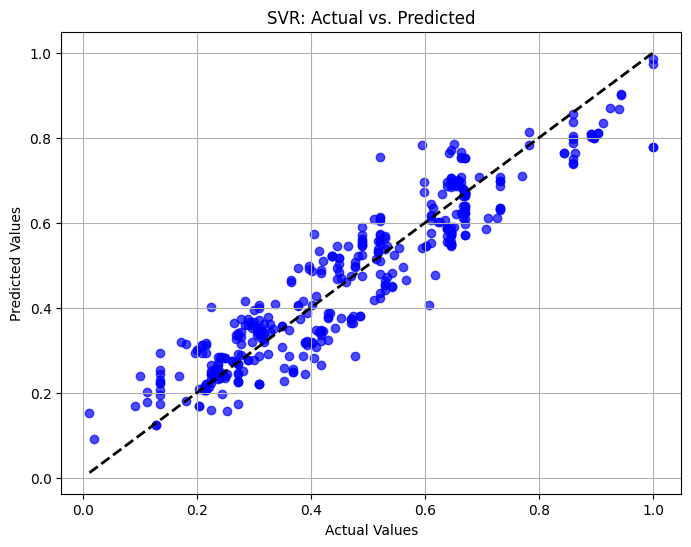

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='b', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("SVR: Actual vs. Predicted")
plt.grid(True)
plt.show()

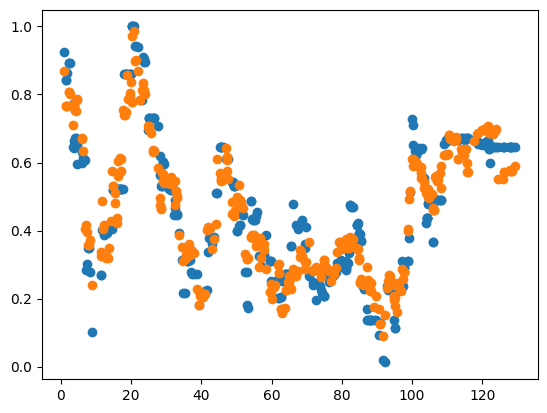

In [38]:
plt.scatter(y_test.index, y_test)
plt.scatter(y_test.index, y_pred)